<a href="https://colab.research.google.com/github/OweT1/personal/blob/main/Sentence_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading in of packages

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [37]:
from google.colab import drive
drive.mount("/content/drive")

!ls /content/drive/MyDrive/'Colab Datasets'/'Sentence Sentimental Analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset.csv


# Reading in of Data

In [38]:
data = pd.read_csv("/content/drive/MyDrive/Colab Datasets/Sentence Sentimental Analysis/dataset.csv", header = None, names = ["Label", "Text"])

print(data.head()) # First column: 1 - positive, 0 - negative
print(data.shape)

   Label                                               Text
0      1  the rock is destined to be the 21st century's ...
1      1  the gorgeously elaborate continuation of " the...
2      1                     effective but too-tepid biopic
3      1  if you sometimes like to go to the movies to h...
4      1  emerges as something rare , an issue movie tha...
(10662, 2)


In [39]:
print(data.columns)
print(type(list(data["Text"])))

Index(['Label', 'Text'], dtype='object')
<class 'list'>


# Model (Pre-built on Hugging Face)
For a start, we will try a pre-built model on Hugging Face that will analyse the text and give us a rating on whether it is `POSITIVE` or `NEGATIVE`.

In [40]:
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english") # device = 0
output = sentiment_pipeline(list(data["Text"]))

In [41]:
new_data = data
new_data["Prediction"] = pd.Series(map(lambda x: x['label'], output))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
new_data["Prediction"] = new_data["Prediction"].map(label_mapping)

In [42]:
print(new_data.head())

print("Accuracy Score: " + str(accuracy_score(new_data["Label"], new_data["Prediction"])))

   Label                                               Text  Prediction
0      1  the rock is destined to be the 21st century's ...           1
1      1  the gorgeously elaborate continuation of " the...           1
2      1                     effective but too-tepid biopic           0
3      1  if you sometimes like to go to the movies to h...           1
4      1  emerges as something rare , an issue movie tha...           1
Accuracy Score: 0.8911086100168824


## Model Evaluation
We will evaluate the model and look at the accuracy of the model. As we can see, the model has an accuracy of around 89%.

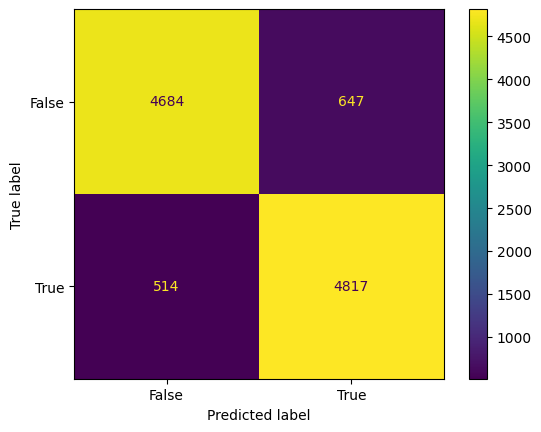

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5331
           1       0.88      0.90      0.89      5331

    accuracy                           0.89     10662
   macro avg       0.89      0.89      0.89     10662
weighted avg       0.89      0.89      0.89     10662



In [43]:
confusionMatrix = confusion_matrix(new_data["Label"], new_data["Prediction"])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print(classification_report(new_data["Label"], new_data["Prediction"]))

# Manual Text Processing & Modelling
Now, we will manually perform the processing of the texts and create a model to predict the sentiment of the text.

In [44]:
#!pip install nltk==3.8.1

import nltk

nltk.download(["stopwords", "punkt", "wordnet"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
X = pd.DataFrame(data["Text"], columns = ["Text"])
y = data["Label"]

## Expanding of Contractions in Text

In [46]:
# Tried using pycontractions but had issues installing it

# !sudo apt install openjdk-8-jdk
# !sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
# !pip install language-check
# !pip install pycontractions
# from pycontractions import Contractions
!pip install contractions

import contractions

In [47]:
# def expand_contractions(text):
#   expanded_text = []
#   for word in text.split():
#     expanded_text.append(contractions.fix(word))
#   return " ".join(expanded_text)

X["Text_con"] = [contractions.fix(text) for text in X["Text"]]

print(X.head())

                                                Text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                            Text_con  
0  the rock is destined to be the 21st century's ...  
1  the gorgeously elaborate continuation of " the...  
2                     effective but too-tepid biopic  
3  if you sometimes like to go to the movies to h...  
4  emerges as something rare , an issue movie tha...  


## Tokenization of text

In [48]:
X["Text_con_token"] = [nltk.word_tokenize(text) for text in X["Text_con"]]

print(X.head())

                                                Text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                            Text_con  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                      Text_con_token  
0  [the, rock, is, destined, to, be, the, 21st, c...  
1  [the, gorgeously, elaborate, continuation, of,...  
2                [effective, but, too-tepid, biopic]  
3  [if, you, sometimes, like, to, go, to, the, mo...  
4  [emerges, as, something, rare, ,, an, issue, m..

## Removing of stopwords and punctuations

In [49]:
stopwords = nltk.corpus.stopwords.words("english")

def remove_punc(words):
  return [w for w in words if w.isalpha()]

def remove_stopwords(words, stopwords):
  return [w.lower() for w in words if w.lower() not in stopwords]

X["Text_con_token_punc"] = [remove_punc(text) for text in X["Text_con_token"]]
X["Text_con_token_punc_stop"] = [remove_stopwords(text, stopwords) for text in X["Text_con_token_punc"]]

print(X.head())

                                                Text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                            Text_con  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                      Text_con_token  \
0  [the, rock, is, destined, to, be, the, 21st, c...   
1  [the, gorgeously, elaborate, continuation, of,...   
2                [effective, but, too-tepid, biopic]   
3  [if, you, sometimes, like, to, go, to, the, mo...   
4  [emerges, as, something, rare, ,, an, issue

## Lemmatization of words

In [50]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(lemmatizer, words):
  return [lemmatizer.lemmatize(word) for word in words]

X["Text_con_token_punc_stop_lemma"] = [lemmatize_text(lemmatizer, text) for text in X["Text_con_token_punc_stop"]]

print(X.head())

                                                Text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                            Text_con  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                      Text_con_token  \
0  [the, rock, is, destined, to, be, the, 21st, c...   
1  [the, gorgeously, elaborate, continuation, of,...   
2                [effective, but, too-tepid, biopic]   
3  [if, you, sometimes, like, to, go, to, the, mo...   
4  [emerges, as, something, rare, ,, an, issue

## Splitting of Data Values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

X_train = pd.DataFrame(X_train).reset_index().drop("index", axis = 1)
X_test = pd.DataFrame(X_test).reset_index().drop("index", axis = 1)
y_train = y_train.reset_index().drop("index", axis = 1)
y_test = y_test.reset_index().drop("index", axis = 1)

print(X_train.shape, X_test.shape)
print(X_train.head())
print(X_test.head())
print(y_train.shape, y_test.shape)

(8529, 6) (2133, 6)
                                                Text  \
0  the overall effect is so completely inane that...   
1  for a shoot-'em-up , ballistic is oddly lifele...   
2           darkly funny and frequently insightful .   
3  a damn fine and a truly distinctive and a deep...   
4  this rich , bittersweet israeli documentary , ...   

                                            Text_con  \
0  the overall effect is so completely inane that...   
1  for a shoot-them-up , ballistic is oddly lifel...   
2           darkly funny and frequently insightful .   
3  a damn fine and a truly distinctive and a deep...   
4  this rich , bittersweet israeli documentary , ...   

                                      Text_con_token  \
0  [the, overall, effect, is, so, completely, ina...   
1  [for, a, shoot-them-up, ,, ballistic, is, oddl...   
2    [darkly, funny, and, frequently, insightful, .]   
3  [a, damn, fine, and, a, truly, distinctive, an...   
4  [this, rich, ,, bitters

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()



## Modelling
We will use a simple neural network to predict the sentiment of the text.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1))

X_train_vectorized = vectorizer.fit_transform(X_train["Text_con"]).todense()
X_test_vectorized = vectorizer.transform(X_test["Text_con"]).todense()

print(X_train_vectorized.shape)
print(X_test_vectorized.shape)

(8529, 16580)
(2133, 16580)


In [53]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(1028, input_shape=(X_train_vectorized.shape[1],), activation='leaky_relu'))
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_vectorized, y_train, epochs=5, batch_size=1028,
                    validation_data=(X_test_vectorized, y_test), verbose=1)

y_pred = model.predict(X_test_vectorized)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6413 - loss: 0.6826 - val_accuracy: 0.7571 - val_loss: 0.5901
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8919 - loss: 0.4409 - val_accuracy: 0.7679 - val_loss: 0.4890
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9515 - loss: 0.1472 - val_accuracy: 0.7647 - val_loss: 0.6499
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9848 - loss: 0.0535 - val_accuracy: 0.7586 - val_loss: 0.8332
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9966 - loss: 0.0196 - val_accuracy: 0.7501 - val_loss: 0.9966
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [54]:
threshold = 0.5
y_pred = pd.DataFrame([1 if result > threshold else 0 for result in y_pred])

print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.7501172058134083


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


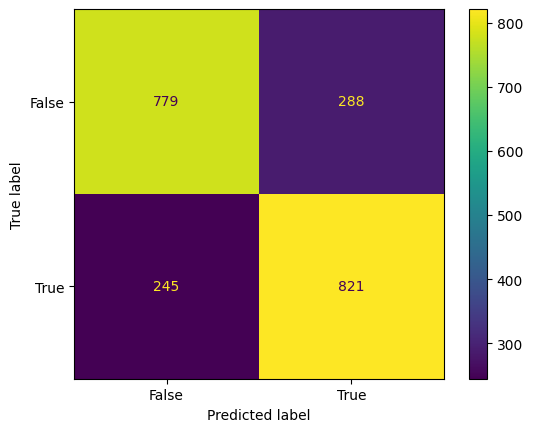

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1067
           1       0.74      0.77      0.75      1066

    accuracy                           0.75      2133
   macro avg       0.75      0.75      0.75      2133
weighted avg       0.75      0.75      0.75      2133



In [55]:
print(type(y_pred))
print(type(y_test))
confusionMatrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print(classification_report(y_test, y_pred))